In [2]:
import pandas as pd
import json
from KDEpy import FFTKDE
from scipy.stats import norm
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import seaborn as sns
import statsmodels.api as sm

In [25]:
# load data frame from csv

df = pd.read_csv("/abcdqc_data/batchserver/output/df.csv")
df.columns = df.columns.str.replace('.', '__')

In [26]:
# generate summary measures for all iqms

iqms = [ 'cjv', 'cnr', 'efc', 'fber', 'fwhm_avg', 'fwhm_x', 'fwhm_y', 'fwhm_z', 'icvs_csf', 'icvs_gm', 'icvs_wm', 'inu_med', 'inu_range',
       'qi_1', 'qi_2', 'rpve_csf', 'rpve_gm', 'rpve_wm', 'size_x', 'size_y', 'size_z', 'snr_csf', 'snr_gm',
       'snr_total', 'snr_wm', 'snrd_csf', 'snrd_gm', 'snrd_total', 'snrd_wm', 'spacing_x', 'spacing_y', 'spacing_z', 'summary_bg_k',
       'summary_bg_mad', 'summary_bg_mean', 'summary_bg_median', 'summary_bg_n', 'summary_bg_p05', 'summary_bg_p95',
       'summary_bg_stdv', 'summary_csf_k', 'summary_csf_mad', 'summary_csf_mean', 'summary_csf_median', 'summary_csf_n',
       'summary_csf_p05', 'summary_csf_p95', 'summary_csf_stdv', 'summary_gm_k', 'summary_gm_mad', 'summary_gm_mean',
       'summary_gm_median', 'summary_gm_n', 'summary_gm_p05', 'summary_gm_p95', 'summary_gm_stdv', 'summary_wm_k',
       'summary_wm_mad', 'summary_wm_mean', 'summary_wm_median', 'summary_wm_n', 'summary_wm_p05', 'summary_wm_p95',
       'summary_wm_stdv', 'tpm_overlap_csf', 'tpm_overlap_gm', 'tpm_overlap_wm', 'wm2max' ]
print(len(iqms))
df[iqms].describe()

68


,cjv,cnr,efc,fber,fwhm_avg,fwhm_x,fwhm_y,fwhm_z,icvs_csf,icvs_gm,...,summary_wm_mean,summary_wm_median,summary_wm_n,summary_wm_p05,summary_wm_p95,summary_wm_stdv,tpm_overlap_csf,tpm_overlap_gm,tpm_overlap_wm,wm2max
count,9121.000000,9121.000000,46486.000000,4.648600e+04,46486.000000,46486.000000,46486.000000,46486.000000,9121.000000,9121.000000,...,9121.000000,9121.000000,9.121000e+03,9121.000000,9121.000000,9121.000000,9121.000000,9121.000000,9121.000000,9121.000000
mean,0.941726,2.269262,0.486912,4.058603e+05,3.124205,2.948277,3.356929,3.067408,0.270531,0.381426,...,1056.343715,1000.370828,1.404359e+05,799.268560,1471.503252,222.917570,0.160151,0.366601,0.418808,0.446773
std,8.664844,1.160687,0.041844,2.972297e+06,0.407197,0.457639,0.444071,0.389993,0.150432,0.153311,...,170.266089,2.495333,7.549592e+04,160.761126,789.086270,305.758539,0.042040,0.174335,0.155878,0.170141
min,0.147467,0.001179,0.334563,1.737272e+00,2.093367,1.362992,1.988724,1.518925,0.076694,0.035580,...,781.089539,989.625488,4.540000e+02,78.321870,1043.637115,24.892166,0.025415,0.026162,0.002069,0.075426
25%,0.414816,1.415085,0.464739,8.840024e+02,2.892313,2.681497,3.087796,2.848585,0.138244,0.374857,...,1000.723267,1000.005554,1.249200e+05,775.139801,1156.166406,85.523224,0.114584,0.242354,0.457715,0.298626
50%,0.494740,2.419663,0.484975,1.336680e+03,3.011051,2.804625,3.252898,2.983262,0.170478,0.459453,...,1009.067139,1000.022217,1.505450e+05,868.372278,1186.463495,100.558212,0.176315,0.480295,0.485665,0.406253
75%,0.694976,2.938966,0.504468,2.642029e+03,3.205388,3.010792,3.520872,3.193240,0.444500,0.479840,...,1019.203003,1000.046997,1.730270e+05,891.814722,1251.643524,134.346298,0.198107,0.505381,0.503926,0.611097
max,747.982512,7.262497,0.816323,2.734691e+08,8.055401,7.734541,10.516916,8.441661,0.534394,0.747801,...,2348.942627,1102.928223,1.006677e+06,963.800021,7432.180225,2365.318359,0.237460,0.563787,0.585728,0.891358


In [27]:
# splitvars:
# Age
# Sex
# Risk of Drug Abuse
# Manual QC
# Task
# Run - 'bids_meta.session_id'?
# Model - 'bids_meta.ManufacturersModelName'
# MFG (manufacturer) - 'bids_meta.Manufacturer'

splitvars = [ 'bids_meta__Manufacturer', 'bids_meta__ManufacturersModelName', 'bids_meta__Modality' ]

df[splitvars].describe()

,bids_meta__Manufacturer,bids_meta__ManufacturersModelName,bids_meta__Modality
count,46486,46486,46486
unique,3,7,1
top,Siemens,Prisma_fit,MR
freq,28771,15593,46486


In [50]:
# FOR TESTING ONLY: create csv of this one KDE
testcsv = pd.DataFrame()
testcsv['efc'] = np.linspace(df.efc.min(), df.efc.max(), num=1000)
testcsv['kde'] = kernel.evaluate(testcsv.efc)

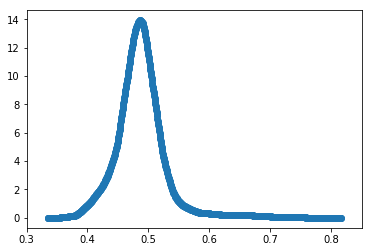

In [52]:
plt.scatter(testcsv.efc, testcsv.kde)

In [51]:
testcsv.to_csv('/abcdqc_data/batchserver/output/testkde.csv', index=False)